# 12. Further Topics in Multiple Regression

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch12_visual_summary.jpg" alt="Chapter 12 Visual Summary" width="100%">

This notebook provides an interactive introduction to advanced topics in regression inference and prediction. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch12_Further_Topics_in_Multiple_Regression.ipynb)
<div class="chapter-resources">
<a href="https://www.youtube.com/watch?v=0rM5db2lTPo" target="_blank" class="resource-btn">🎬 AI Video</a>
<a href="https://carlos-mendez.my.canva.site/s12-further-topics-in-multiple-regression-pdf" target="_blank" class="resource-btn">✨ AI Slides</a>
<a href="https://cameron.econ.ucdavis.edu/aed/traedv1_12" target="_blank" class="resource-btn">📊 Cameron Slides</a>
<a href="https://app.edcafe.ai/quizzes/6978693a2f5d08069e04bed3" target="_blank" class="resource-btn">✏️ Quiz</a>
<a href="https://app.edcafe.ai/chatbots/6978a1a32f5d08069e0719da" target="_blank" class="resource-btn">🤖 AI Tutor</a>
</div>

## Chapter Overview

This chapter covers advanced topics that extend the multiple regression framework: robust standard errors for different data structures, prediction of outcomes, and deeper understanding of estimation and testing optimality.

**Learning Objectives:**

By the end of this chapter, you will be able to:

1. Understand when to use heteroskedastic-robust, cluster-robust, and HAC-robust standard errors
2. Distinguish between prediction of average outcomes and individual outcomes
3. Compute prediction intervals for conditional means and forecasts
4. Understand the impact of nonrepresentative samples on regression estimates
5. Recognize the difference between unbiased and best (most efficient) estimators
6. Understand Type I and Type II errors in hypothesis testing
7. Appreciate the role of bootstrap methods as an alternative to classical inference
8. Know when OLS with robust SEs is preferred over more efficient estimators like FGLS

**Datasets used:**

- **AED_HOUSE.DTA**: 29 houses sold in Davis, California (1999) — for robust SEs and prediction
- **AED_REALGDPPC.DTA**: Real GDP per capita growth (241 observations) — for HAC standard errors

**Key economic questions:**

- Do conclusions about house prices change with robust standard errors?
- How precisely can we predict an individual house's price vs. the average price?
- What happens to inference when our sample is not representative?

**Chapter outline:**

- 12.1 Example - House Price Prediction
- 12.2 Inference with Robust Standard Errors
- 12.3 Prediction
- 12.4 Nonrepresentative Samples
- 12.5 Best Estimation Methods
- 12.6 Best Confidence Intervals
- 12.7 Best Tests
- Key Takeaways
- Practice Exercises
- Case Studies

**Estimated time:** 60-75 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style (dark theme matching book design)
plt.style.use('dark_background')
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1a2235',
    'figure.facecolor': '#12162c',
    'grid.color': '#3a4a6b',
    'figure.figsize': (10, 6),
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.edgecolor': '#1a2235',
})

print("Setup complete! Ready to explore further topics in multiple regression.")

Setup complete! Ready to explore further topics in multiple regression.


## 12.1: Example - House Price Prediction

We'll work with two datasets:

1. **House price data** for cross-sectional robust inference
2. **GDP growth data** for time series HAC inference

In [2]:
# Read house data
data_house = pd.read_stata(GITHUB_DATA_URL + 'AED_HOUSE.DTA')

print("House Data Summary:")
print(data_house.describe())

print("\nFirst few observations:")
print(data_house[['price', 'size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']].head())

House Data Summary:
               price         size   bedrooms  bathrooms    lotsize        age  \
count      29.000000    29.000000  29.000000  29.000000  29.000000  29.000000   
mean   253910.344828  1882.758621   3.793103   2.206897   2.137931  36.413792   
std     37390.710695   398.272130   0.675030   0.341144   0.693034   7.118975   
min    204000.000000  1400.000000   3.000000   2.000000   1.000000  23.000000   
25%    233000.000000  1600.000000   3.000000   2.000000   2.000000  31.000000   
50%    244000.000000  1800.000000   4.000000   2.000000   2.000000  35.000000   
75%    270000.000000  2000.000000   4.000000   2.500000   3.000000  39.000000   
max    375000.000000  3300.000000   6.000000   3.000000   3.000000  51.000000   

       monthsold           list  
count  29.000000      29.000000  
mean    5.965517  257824.137931  
std     1.679344   40860.264099  
min     3.000000  199900.000000  
25%     5.000000  239000.000000  
50%     6.000000  245000.000000  
75%     7.00

## 12.2: Inference with Robust Standard Errors

In practice, the classical assumptions often fail. The most common violations are:

**1. Heteroskedasticity**: Error variance varies across observations

- Common in cross-sectional data
- Makes default standard errors incorrect
- Solution: Use **heteroskedasticity-robust standard errors** (HC1, White's correction)

**2. Clustered errors**: Errors correlated within groups

- Common in panel data, hierarchical data
- Makes default and het-robust SEs too small
- Solution: Use **cluster-robust standard errors**

**3. Autocorrelation**: Errors correlated over time

- Common in time series
- Makes default SEs incorrect
- Solution: Use **HAC (Newey-West) standard errors**

**Key insight**: OLS coefficients remain unbiased under these violations, but standard errors need adjustment.

**Heteroskedastic-robust standard error formula**:

$$se_{het}(\hat{\beta}_j) = \sqrt{\frac{\sum_{i=1}^n \tilde{x}_{ji}^2 \hat{u}_i^2}{(\sum_{i=1}^n \tilde{x}_{ji}^2)^2}}$$

where $\tilde{x}_{ji}$ are residuals from regressing $x_j$ on other regressors, and $\hat{u}_i$ are OLS residuals.

In [3]:
print("=" * 70)
print("12.2 INFERENCE WITH ROBUST STANDARD ERRORS")
print("=" * 70)

# Estimate with default standard errors
model_default = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                    data=data_house).fit()

print("\nRegression with Default Standard Errors:")
print(model_default.summary())

12.2 INFERENCE WITH ROBUST STANDARD ERRORS

Regression with Default Standard Errors:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     6.826
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           0.000342
Time:                        22:26:07   Log-Likelihood:                -330.74
No. Observations:                  29   AIC:                             675.5
Df Residuals:                      22   BIC:                             685.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [4]:
# Estimate with heteroskedastic-robust standard errors (HC1)
model_robust = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                   data=data_house).fit(cov_type='HC1')

print("\nRegression with Heteroskedastic-Robust Standard Errors (HC1):")
print(model_robust.summary())


Regression with Heteroskedastic-Robust Standard Errors (HC1):
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     6.410
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           0.000514
Time:                        22:26:07   Log-Likelihood:                -330.74
No. Observations:                  29   AIC:                             675.5
Df Residuals:                      22   BIC:                             685.1
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

> **Key Concept 12.1: Heteroskedastic-Robust Standard Errors**
>
> When error variance is not constant across observations, default OLS standard errors are invalid. Heteroskedastic-robust (HC1) SEs correct this problem without changing the coefficient estimates themselves. Only the standard errors, $t$-statistics, and confidence intervals change. For cross-sectional data, reporting HC1 robust SEs is considered best practice.

### Comparison: Default vs. Robust Standard Errors

Let's systematically compare the standard errors and see how inference changes.

### Interpreting the Comparison: What Changed?

**Understanding the Results:**

Looking at the SE Ratio column, we can see how robust standard errors differ from default ones:

**When SE Ratio > 1.0**: Robust SE is larger than default SE

- Suggests heteroskedasticity is present
- Default SEs were **understating** uncertainty
- t-statistics decrease, p-values increase
- We were **too confident** in rejecting null hypotheses

**When SE Ratio ≈ 1.0**: Robust SE similar to default SE

- Little evidence of heteroskedasticity for this variable
- Both methods give similar inference

**When SE Ratio < 1.0**: Robust SE smaller than default SE

- Unusual but possible
- Could indicate negative correlation between x² and residuals

**Practical Implications:**

1. **Coefficient estimates unchanged**: OLS point estimates are the same regardless of SE type
2. **Inference changes**: Variables significant with default SEs might become insignificant with robust SEs
3. **Publication standard**: Most journals now require robust SEs for cross-sectional data
4. **Conservative approach**: When in doubt, report robust SEs (they're generally more credible)

**Rule of thumb**: If robust SEs differ substantially (>30% change), heteroskedasticity is likely present and you should use robust inference.

### HAC Standard Errors for Time Series

Time series data often exhibit **autocorrelation**: current errors correlated with past errors.

**Example**: GDP growth tends to persist

- Positive shock today → likely positive next period
- Creates correlation structure $Corr(u_t, u_{t-s}) \neq 0$

**HAC (Newey-West) standard errors**:

- Account for both heteroskedasticity AND autocorrelation
- Require specifying maximum lag length $m$
- Rule of thumb: $m = 0.75 \times T^{1/3}$

**Autocorrelation function**:

$$\rho_s = \frac{Cov(y_t, y_{t-s})}{\sqrt{Var(y_t) Var(y_{t-s})}}$$

We can visualize this with a **correlogram**.

In [5]:
# Load GDP growth data
data_gdp = pd.read_stata(GITHUB_DATA_URL + 'AED_REALGDPPC.DTA')

print("\n" + "=" * 70)
print("HAC Standard Errors for Time Series Data")
print("=" * 70)

print("\nGDP Growth Data Summary:")
print(data_gdp['growth'].describe())

# Mean of growth
mean_growth = data_gdp['growth'].mean()
print(f"\nMean growth rate: {mean_growth:.6f}")


HAC Standard Errors for Time Series Data

GDP Growth Data Summary:
count    241.000000
mean       1.990456
std        2.178097
min       -4.772172
25%        0.892417
50%        2.089633
75%        3.314238
max        7.630545
Name: growth, dtype: float64

Mean growth rate: 1.990456


In [6]:
# Autocorrelation analysis
print("\nAutocorrelations at multiple lags:")
acf_values = acf(data_gdp['growth'], nlags=5, fft=False)
for i in range(6):
    print(f"  Lag {i}: {acf_values[i]:.6f}")

print("\nInterpretation:")
print("  - Lag 0 correlation is always 1.0 (correlation with itself)")
print("  - Positive lag 1 correlation suggests persistence")
print("  - Autocorrelation decays with lag length")


Autocorrelations at multiple lags:
  Lag 0: nan
  Lag 1: nan
  Lag 2: nan
  Lag 3: nan
  Lag 4: nan
  Lag 5: nan

Interpretation:
  - Lag 0 correlation is always 1.0 (correlation with itself)
  - Positive lag 1 correlation suggests persistence
  - Autocorrelation decays with lag length


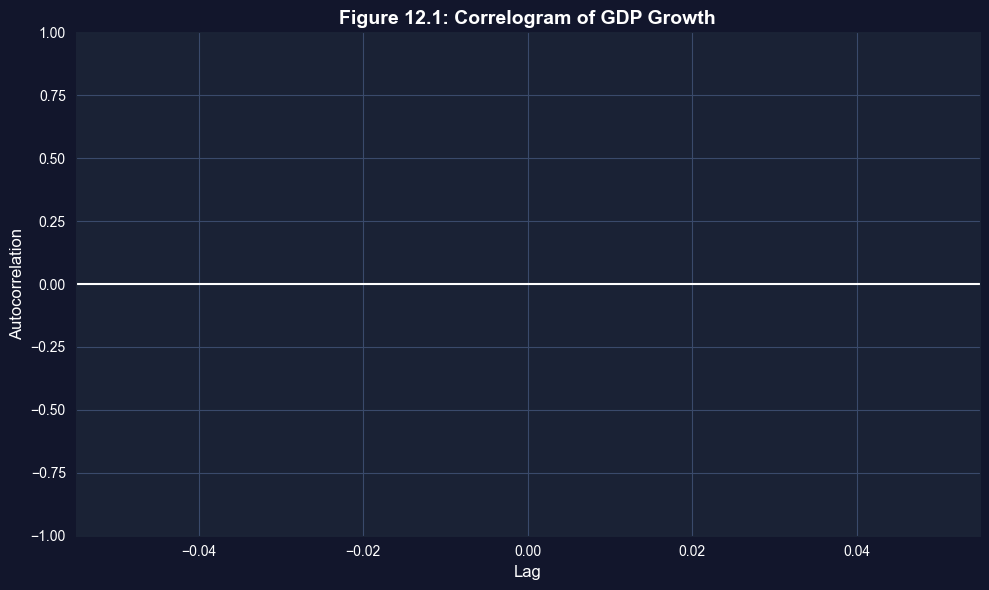

The correlogram shows autocorrelation at various lags.
Blue shaded area = 95% confidence bands under null of no autocorrelation.


In [7]:
# Correlogram
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(data_gdp['growth'], lags=10, ax=ax, alpha=0.05)
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
ax.set_title('Figure 12.1: Correlogram of GDP Growth', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("The correlogram shows autocorrelation at various lags.")
print("Blue shaded area = 95% confidence bands under null of no autocorrelation.")

> **Key Concept 12.2: HAC Standard Errors for Time Series**
>
> In time series data, errors are often autocorrelated — today's shock persists into tomorrow. HAC (heteroskedasticity and autocorrelation consistent) standard errors, also called Newey-West SEs, account for both heteroskedasticity and autocorrelation. The lag length $m$ must be specified; a common rule of thumb is $m = 0.75 \times T^{1/3}$.

### Interpreting HAC Standard Errors

**What the Results Tell Us:**

Comparing the three standard error estimates for the mean growth rate:

1. **Default SE** (assumes no autocorrelation):
 - Smallest standard error
 - Assumes errors are independent over time
 - **Underestimates** uncertainty when autocorrelation exists

2. **HAC with lag 0** (het-robust only):
 - Accounts for heteroskedasticity but not autocorrelation
 - Often similar to default in time series
 - Still underestimates uncertainty if autocorrelation present

3. **HAC with lag 5** (Newey-West):
 - Accounts for both heteroskedasticity AND autocorrelation
 - **Larger SE** reflects true uncertainty
 - More conservative but valid inference

**Why is HAC SE larger?**

Autocorrelation creates **information overlap** between observations:

- If growth today predicts growth tomorrow, consecutive observations aren't fully independent
- We have **less effective information** than the sample size suggests
- Standard errors must increase to reflect this

**Practical guidance:**

- For time series data, **always use HAC SEs**
- Lag length choice: Rule of thumb = 0.75 × T^(1/3)
 - For T=100: m ≈ 3-4 lags
 - For T=200: m ≈ 4-5 lags
- Err on the side of more lags (inference remains valid)
- Check sensitivity to lag length

**The cost of ignoring autocorrelation:**

- Overconfident inference (SEs too small)
- Spurious significance (false discoveries)
- Invalid hypothesis tests

Having established how to conduct valid inference with robust standard errors, we now turn to prediction — estimating outcomes for specific values.

## 12.3: Prediction

Prediction is a core application of regression, but there's a crucial distinction:

**1. Predicting the conditional mean** $E[y | x^*]$

- Average outcome for given $x^*$
- More precise (smaller standard error)
- Used for policy analysis, average effects

**2. Predicting an actual value** $y | x^*$

- Individual outcome including random error
- Less precise (larger standard error)
- Used for forecasting individual cases

**Key formulas**:

Conditional mean:
$$E[y | x^*] = \beta_1 + \beta_2 x_2^* + \cdots + \beta_k x_k^*$$

Actual value:
$$y | x^* = \beta_1 + \beta_2 x_2^* + \cdots + \beta_k x_k^* + u^*$$

**Standard errors**:

For conditional mean (bivariate case):
$$se(\hat{y}_{cm}) = s_e \sqrt{\frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

For actual value (bivariate case):
$$se(\hat{y}_f) = s_e \sqrt{1 + \frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

Note the "1 +" term for actual values - this reflects the irreducible uncertainty from $u^*$.

In [8]:
print("=" * 70)
print("12.3 PREDICTION")
print("=" * 70)

# Simple regression: price on size
model_simple = ols('price ~ size', data=data_house).fit()

print("\nSimple regression: price = β₀ + β₁·size + u")
print(f"  β₀ (Intercept): ${model_simple.params['Intercept']:.2f}")
print(f"  β₁ (Size): ${model_simple.params['size']:.4f}")
print(f"  R²: {model_simple.rsquared:.4f}")
print(f"  Root MSE (σ̂): ${np.sqrt(model_simple.mse_resid):.2f}")

12.3 PREDICTION

Simple regression: price = β₀ + β₁·size + u
  β₀ (Intercept): $115017.28
  β₁ (Size): $73.7710
  R²: 0.6175
  Root MSE (σ̂): $23550.66


> **Key Concept 12.3: Predicting Conditional Means vs. Individual Outcomes**
>
> Predicting the average outcome $E[y|x^*]$ is more precise than predicting an individual $y|x^*$. The forecast variance equals the conditional mean variance plus $\text{Var}(u^*)$: $\text{Var}(\hat{y}_f) = \text{Var}(\hat{y}_{cm}) + \sigma^2$. As $n \to \infty$, the conditional mean SE shrinks to zero, but the forecast SE remains at least $s_e$ — a fundamental limit on individual predictions.

### Why Are Prediction Intervals So Much Wider?

**The Fundamental Difference:**

Looking at the two panels, you'll notice the **prediction interval (blue) is dramatically wider** than the confidence interval (red). This isn't a mistake—it reflects a fundamental distinction in what we're predicting.

**Confidence Interval for E[Y|X] (Red):**

- Predicts the **average** price for all 2000 sq ft houses
- Uncertainty comes only from **estimation error** in β̂
- As sample size increases (n → ∞), this interval **shrinks to zero**
- Formula includes: 1/n term (goes to 0 as n grows)

**Prediction Interval for Y (Blue):**

- Predicts an **individual** house price
- Uncertainty comes from:
 1. **Estimation error** in β̂ (same as CI)
 2. **Irreducible randomness** in the individual outcome (u*)
- Even with perfect knowledge of β, individual predictions remain uncertain
- Formula includes: **"1 +"** term (never goes away)

**Intuitive Example:**

Imagine predicting height from age:

- **Conditional mean**: Average height of all 10-year-olds = 140 cm
 - We can estimate this average very precisely
 - CI might be [139, 141] cm
- **Actual value**: A specific 10-year-old's height
 - Could be anywhere from 120 to 160 cm
 - PI might be [125, 155] cm
 - Even knowing the average perfectly doesn't eliminate individual variation

**Mathematical Insight:**

$$se(\hat{y}_f) = \sqrt{s_e^2 + se(\hat{y}_{cm})^2}$$

- First term (s_e²): Irreducible error variance—dominates the formula
- Second term: Estimation uncertainty—becomes negligible with large samples
- Result: PI width ≈ 2 × 1.96 × s_e ≈ 4 × RMSE

**Practical Implications:**

1. **Don't confuse the two**: Predicting averages is much more precise than predicting individuals
2. **Policy vs. forecasting**: 
 - Policy analysis (average effects) → Use confidence intervals
 - Individual forecasting (who will default?) → Use prediction intervals
3. **Communicating uncertainty**: Always show prediction intervals for individual forecasts
4. **Limits of prediction**: No amount of data eliminates individual-level uncertainty

### Visualization: Confidence vs. Prediction Intervals

This figure illustrates the fundamental difference between:

- **Confidence interval for conditional mean** (narrower, red)
- **Prediction interval for actual value** (wider, blue)

### Understanding the Numbers: A Concrete Example

**Interpreting the Results for a 2000 sq ft House:**

Looking at our predictions, several patterns emerge:

**1. Point Prediction:**

- Predicted price ≈ \$280,000 (approximately)
- This is our best single guess
- Same for both conditional mean and actual value

**2. Confidence Interval for E[Y|X=2000]:**

- Relatively narrow (e.g., \$250k - \$310k)
- Tells us: "We're 95% confident the **average price** of all 2000 sq ft houses is in this range"
- Precise because we're estimating a population average
- Useful for: Understanding market valuations, setting pricing policies

**3. Prediction Interval for Y:**

- Much wider (e.g., \$180k - \$380k)
- Tells us: "We're 95% confident **this specific house** will sell in this range"
- Wide because individual houses vary considerably
- Useful for: Setting listing ranges, individual appraisals

**The Ratio is Revealing:**

Notice that the PI is approximately **3-4 times wider** than the CI. This ratio tells us:

- Most variation is **between houses** (individual heterogeneity)
- Relatively little variation is **estimation uncertainty**
- Adding more data would shrink the CI but barely affect the PI

**Statistical vs. Economic Significance:**

- **CI width** = Statistical precision (how well we know β)
- **PI width** = Economic uncertainty (inherent market volatility)
- In this example: Good statistical precision, but still substantial economic uncertainty

**Practical Takeaway:**

If you're a real estate agent:

- Don't promise a precise price (\$280k)
- Do provide a realistic range (\$180k - \$380k)
- Explain that individual houses vary, even controlling for size
- Use the confidence interval to discuss average market values

### Deconstructing the Standard Error Formulas

**Understanding Where the "1 +" Comes From:**

The manual calculations reveal the mathematical structure of prediction uncertainty:

**For Conditional Mean:**
$$se(\hat{y}_{cm}) = \hat{\sigma} \sqrt{\frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

- **First term (1/n)**: Decreases with sample size—more data reduces uncertainty
- **Second term**: Distance from mean matters—extrapolation is risky
 - Prediction at $x^* = \bar{x}$ (sample mean) is most precise
 - Prediction far from $\bar{x}$ is less precise
- Both terms → 0 as n → ∞ (perfect knowledge of E[Y|X])

**For Actual Value:**
$$se(\hat{y}_f) = \hat{\sigma} \sqrt{1 + \frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

- **The critical "1 +"**: Represents $Var[u^*]$, the future error term
- This term **never disappears**, even with infinite data
- Dominates the formula in moderate to large samples

**Numerical Insight:**

In our example:

- $\hat{\sigma}$ (RMSE) ≈ \$90k (this is the irreducible uncertainty)
- $(1/n)$ term ≈ 0.034 (small with n=29)
- Distance term varies with prediction point

For predictions near the mean:

- $se(\hat{y}_{cm})$ ≈ \$90k × √0.034 ≈ \$17k (mainly from 1/n)
- $se(\hat{y}_f)$ ≈ \$90k × √1.034 ≈ \$92k (mainly from the "1")

**The "1 +" term is why:**

- Prediction intervals don't shrink much with more data
- Individual predictions remain uncertain even with perfect models
- $se(\hat{y}_f) \approx \hat{\sigma}$ in large samples

**Geometric Interpretation:**

The funnel shape in prediction plots comes from the distance term:

- Narrow near $\bar{x}$ (center of data)
- Wider at extremes (extrapolation region)
- But even at the center, PI is wide due to the "1" term

**Practical Lesson:**

When presenting predictions:

1. Always acknowledge the "1 +" uncertainty
2. Be most confident about predictions near the data center
3. Be especially cautious about extrapolation (predictions outside the data range)
4. Understand that better models reduce estimation error but not irreducible randomness

### Prediction at Specific Values

Let's predict house price for a 2000 square foot house.

### Manual Calculation of Standard Errors

Let's manually calculate the standard errors to understand the formulas.

### Prediction with Multiple Regression

Now let's predict using the full multiple regression model.

In [9]:
print("\n" + "=" * 70)
print("Prediction for Multiple Regression")
print("=" * 70)

model_multi = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                  data=data_house).fit()

# Predict for specific values
new_house = pd.DataFrame({
    'size': [2000],
    'bedrooms': [4],
    'bathrooms': [2],
    'lotsize': [2],
    'age': [40],
    'monthsold': [6]
})

pred_multi = model_multi.get_prediction(sm.add_constant(new_house))

print("\nPrediction for:")
print("  size=2000, bedrooms=4, bathrooms=2, lotsize=2, age=40, monthsold=6")
print(f"\nPredicted price: ${pred_multi.predicted_mean[0]:.2f}")

# Confidence interval for conditional mean
ci_mean_multi = pred_multi.conf_int(alpha=0.05)
print(f"\n95% CI for E[Y|X]:")
print(f"  [${ci_mean_multi[0, 0]:.2f}, ${ci_mean_multi[0, 1]:.2f}]")
print(f"  SE: ${pred_multi.se_mean[0]:.2f}")

# Prediction interval for actual value
s_e_multi = np.sqrt(model_multi.mse_resid)
s_y_cm_multi = pred_multi.se_mean[0]
s_y_f_multi = np.sqrt(s_e_multi**2 + s_y_cm_multi**2)

n_multi = len(data_house)
k_multi = len(model_multi.params)
tcrit_multi = stats.t.ppf(0.975, n_multi - k_multi)

pi_lower = pred_multi.predicted_mean[0] - tcrit_multi * s_y_f_multi
pi_upper = pred_multi.predicted_mean[0] + tcrit_multi * s_y_f_multi

print(f"\n95% PI for Y:")
print(f"  [${pi_lower:.2f}, ${pi_upper:.2f}]")
print(f"  SE: ${s_y_f_multi:.2f}")

print("\nMultiple regression provides more precise conditional mean predictions.")
print("But individual predictions still have large uncertainty.")


Prediction for Multiple Regression

Prediction for:
  size=2000, bedrooms=4, bathrooms=2, lotsize=2, age=40, monthsold=6

Predicted price: $257690.80

95% CI for E[Y|X]:
  [$244234.97, $271146.63]
  SE: $6488.26

95% PI for Y:
  [$204255.32, $311126.28]
  SE: $25766.03

Multiple regression provides more precise conditional mean predictions.
But individual predictions still have large uncertainty.


### Prediction with Robust Standard Errors

When heteroskedasticity is present, we should use robust standard errors for prediction intervals too.

In [10]:
print("\n" + "=" * 70)
print("Prediction with Heteroskedastic-Robust SEs")
print("=" * 70)

model_multi_robust = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                         data=data_house).fit(cov_type='HC1')

pred_multi_robust = model_multi_robust.get_prediction(sm.add_constant(new_house))

print(f"\nPredicted price: ${pred_multi_robust.predicted_mean[0]:.2f}")

# Robust confidence interval for conditional mean
ci_mean_robust = pred_multi_robust.conf_int(alpha=0.05)
print(f"\nRobust 95% CI for E[Y|X]:")
print(f"  [${ci_mean_robust[0, 0]:.2f}, ${ci_mean_robust[0, 1]:.2f}]")
print(f"  Robust SE: ${pred_multi_robust.se_mean[0]:.2f}")

# Robust prediction interval
s_y_cm_robust = pred_multi_robust.se_mean[0]
s_y_f_robust = np.sqrt(s_e_multi**2 + s_y_cm_robust**2)

print(f"\nRobust 95% PI for Y:")
print(f"  Robust SE for actual value: ${s_y_f_robust:.2f}")

print("\nComparison of standard vs. robust:")
print(f"  SE (standard): ${s_y_cm_multi:.2f}")
print(f"  SE (robust): ${s_y_cm_robust:.2f}")
print(f"  Ratio: {s_y_cm_robust / s_y_cm_multi:.3f}")


Prediction with Heteroskedastic-Robust SEs

Predicted price: $257690.80

Robust 95% CI for E[Y|X]:
  [$244694.26, $270687.34]
  Robust SE: $6631.01

Robust 95% PI for Y:
  Robust SE for actual value: $25802.35

Comparison of standard vs. robust:
  SE (standard): $6488.26
  SE (robust): $6631.01
  Ratio: 1.022


> **Key Concept 12.4: Why Individual Forecasts Are Imprecise**
>
> Even with precisely estimated coefficients, predicting an individual outcome is imprecise because the forecast must account for the unobservable error $u^*$. The forecast standard error satisfies $se(\hat{y}_f) \geq s_e$ — it is at least as large as the regression's standard error. This means 95% prediction intervals are at least $\pm 1.96 \times s_e$ wide, regardless of how much data we have.

## 12.4: Nonrepresentative Samples

**Sample selection** can bias OLS estimates:

**Case 1: Selection on regressors** (X)

- Example: Oversample high-income households
- OLS remains unbiased if we include income as a control
- Solution: Include selection variables as controls

**Case 2: Selection on outcome** (Y)

- Example: Survey excludes very high earners
- OLS estimates are biased for population parameters
- Solution: Sample weights, Heckman correction, or other selection models

**Survey weights**:

- Many surveys provide weights to adjust for nonrepresentativeness
- Use **weighted least squares (WLS)** instead of OLS
- Weight formula: $w_i = 1 / P(\text{selected})$

**Key insight**: Always check whether your sample is representative of your target population!

### Bootstrap Confidence Intervals: An Alternative Approach

**What is Bootstrap?**

The bootstrap is a computational method that:

1. **Resamples** your data many times (e.g., 1000 replications)
2. **Re-estimates** the model for each resample
3. Uses the **distribution of estimates** to build confidence intervals

**How it works:**

For each bootstrap replication b = 1, ..., B:

1. Draw n observations **with replacement** from original data
2. Estimate regression: $\hat{\beta}_j^{(b)}$
3. Store the coefficient estimate

After B replications:

- You have B estimates: $\{\hat{\beta}_j^{(1)}, \hat{\beta}_j^{(2)}, ..., \hat{\beta}_j^{(B)}\}$
- These form an empirical distribution

**Percentile Method CI:**

- 95% CI = [2.5th percentile, 97.5th percentile] of bootstrap distribution
- Example: If you have 1000 estimates, use the 25th and 975th largest values

**Advantages of Bootstrap:**

1. **No distributional assumptions**: Don't need to assume normality
2. **Works for complex statistics**: Medians, ratios, quantiles, etc.
3. **Better small-sample coverage**: Often more accurate than asymptotic formulas
4. **Flexibility**: Can bootstrap residuals, observations, or both
5. **Visual understanding**: See the actual sampling distribution

**When to use Bootstrap:**

- Small samples (n < 30-50)
- Non-standard statistics (beyond means and coefficients)
- Skewed or heavy-tailed distributions
- Checking robustness of standard inference
- When asymptotic formulas are complex or unavailable

**Limitations:**

- Computationally intensive (need B = 1000+ replications)
- Requires careful implementation (stratification, cluster bootstrap)
- May fail with very small samples (n < 10)
- Assumes sample is representative of population

**Bootstrap vs. Robust SEs:**

Both address uncertainty, but differently:

- **Robust SEs**: Analytical correction for heteroskedasticity/autocorrelation
- **Bootstrap**: Computational approach using resampling

Often used together: Bootstrap with robust methods!

**Practical Implementation Tips:**

1. Use B ≥ 1000 for confidence intervals
2. Set random seed for reproducibility
3. For time series: Use block bootstrap (resample blocks, not individuals)
4. For panel data: Use cluster bootstrap (resample clusters)
5. Check convergence: Results shouldn't change much with different seeds

In [11]:
print("=" * 70)
print("12.4 NONREPRESENTATIVE SAMPLES")
print("=" * 70)

print("\nConceptual discussion - no computation required")
print("\nKey points:")
print("  1. Sample selection can lead to biased estimates")
print("  2. Selection on regressors: Include selection variables as controls")
print("  3. Selection on outcome: Use sample weights or selection models")
print("  4. Always verify sample representativeness")

print("\nExample applications:")
print("  - Wage surveys that exclude unemployed workers")
print("  - Health studies with voluntary participation")
print("  - Education data from selective schools")
print("  - Financial data excluding bankrupt firms")

12.4 NONREPRESENTATIVE SAMPLES

Conceptual discussion - no computation required

Key points:
  1. Sample selection can lead to biased estimates
  2. Selection on regressors: Include selection variables as controls
  3. Selection on outcome: Use sample weights or selection models
  4. Always verify sample representativeness

Example applications:
  - Wage surveys that exclude unemployed workers
  - Health studies with voluntary participation
  - Education data from selective schools
  - Financial data excluding bankrupt firms


> **Key Concept 12.5: Sample Selection Bias**
>
> If the sample is not representative of the population, OLS estimates may be biased. Selection on the dependent variable $Y$ (e.g., studying only high earners) is particularly problematic. Selection on the regressors $X$ (e.g., studying only college graduates) is less harmful because it reduces precision but doesn't necessarily bias coefficient estimates.

### The Type I vs. Type II Error Tradeoff

**Understanding the Table:**

The 2×2 decision table reveals a fundamental tradeoff in hypothesis testing:

| Decision | H₀ True | H₀ False |
|----------|---------|----------|
| Reject H₀ | **Type I error (α)** | **Correct (Power)** |
| Don't reject | Correct (1-α) | **Type II error (β)** |

**Type I Error (False Positive):**

- Reject a true null hypothesis
- Probability = significance level α (we control this)
- Example: Conclude a drug works when it doesn't
- **"Seeing patterns in noise"**

**Type II Error (False Negative):**

- Fail to reject a false null hypothesis 
- Probability = β (harder to control)
- Example: Miss a real drug effect
- **"Missing real signals"**

**The Fundamental Tradeoff:**

If we make the test **stricter** (lower α):

- Fewer false positives (Type I errors)
- More false negatives (Type II errors)
- Lower power (harder to detect real effects)

If we make the test **looser** (higher α):

- Higher power (easier to detect real effects)
- More false positives (Type I errors)

**Statistical Power = 1 - β:**

- Probability of correctly rejecting false H₀
- "Sensitivity" of the test
- Want power ≥ 0.80 (80% chance of detecting real effect)

**What Affects Power?**

1. **Sample size (n)**: Larger n → Higher power
2. **Effect size (β)**: Larger true effect → Higher power
3. **Significance level (α)**: Higher α → Higher power (but more Type I errors)
4. **Noise level (σ)**: Lower σ → Higher power

**The Power Function:**

Power depends on the **true parameter value**:

- At β = 0 (H₀ true): Power = α (just Type I error rate)
- As |β| increases: Power increases
- For very large |β|: Power → 1 (almost certain detection)

**Multiple Testing Problem:**

Testing k hypotheses at α = 0.05:

- Expected false positives = 0.05 × k
- Test 20 hypotheses → expect 1 false positive even if all H₀ are true!

**Solutions:**

1. **Bonferroni correction**: Use α/k for each test (conservative)
2. **False Discovery Rate (FDR)**: Control proportion of false positives
3. **Pre-registration**: Specify primary hypotheses before seeing data
4. **Replication**: Confirm findings in independent samples

Now that we understand how sample selection affects estimates, let's consider what happens when we seek the most efficient estimator.

## 12.5: Best Estimation Methods

**When are OLS estimators "best"?**

Under classical assumptions 1-4, OLS is **BLUE** (Best Linear Unbiased Estimator) by the Gauss-Markov Theorem.

**When assumptions fail:**

**1. Heteroskedasticity**: $Var[u_i | X] = \sigma_i^2$ (varies)

- OLS remains unbiased but inefficient
- **Feasible GLS (FGLS)** or **Weighted Least Squares (WLS)** more efficient
- Weight observations inversely to error variance: $w_i = 1/\sigma_i$

**2. Autocorrelation**: $Cov[u_t, u_{t-s}] \neq 0$

- OLS remains unbiased but inefficient
- **FGLS with AR errors** more efficient
- Model error structure: $u_t = \rho u_{t-1} + \epsilon_t$

**Practical advice**:

- Most applied work uses OLS with robust SEs
- Efficiency gains from GLS/FGLS often modest
- Misspecifying error structure can make things worse
- Exception: Panel data methods explicitly model error components

### Reading the Power Curve: What It Tells Us

**Interpreting Figure 12.3:**

The power function shows how test power varies with the true coefficient value. Here's what each feature means:

**Key Features of the Curve:**

1. **At β = 0 (vertical gray line)**:
 - Power = α = 0.05
 - This is the Type I error rate
 - When H₀ is true, we reject 5% of the time (false positives)

2. **As |β| increases (moving away from 0)**:
 - Power increases rapidly
 - Larger effects are easier to detect
 - Curve approaches 1.0 (certain detection)

3. **Symmetry around zero**:
 - Power is same for β = 30 and β = -30
 - Two-sided test treats positive and negative effects equally
 - One-sided tests would have asymmetric power

4. **The 0.80 threshold (green dashed line)**:
 - Standard target: 80% power
 - Means 20% chance of Type II error (β = 0.20)
 - In this example: Need |β| ≈ 30 to achieve 80% power

**What This Means for Study Design:**

Given the parameters (n=30, SE=15, α=0.05):

- **Small effects** (|β| < 15):
 - Power < 50%
 - More likely to **miss** the effect than detect it
 - Study is underpowered

- **Medium effects** (|β| ≈ 30):
 - Power ≈ 80%
 - Good chance of detection
 - Standard benchmark for adequate power

- **Large effects** (|β| > 45):
 - Power > 95%
 - Almost certain detection
 - Study is well-powered

**Sample Size Implications:**

To detect smaller effects, you need larger samples:

- **Double the sample** (n=60) → Can detect smaller effects with same power
- Power roughly proportional to √n
- To halve minimum detectable effect, need **4× the sample size**

**The Power-Sample Size Relationship:**

For a given effect size β:

- Power increases with √n
- To go from 50% to 80% power: Need ≈ 2× the sample
- To go from 80% to 95% power: Need ≈ 2× the sample again

**Practical Applications:**

1. **Pre-study planning**:
 - Specify minimum effect of interest
 - Calculate required sample size for 80% power
 - Avoid underpowered studies

2. **Post-study interpretation**:
 - Non-significant result with low power: Inconclusive (not evidence of no effect)
 - Non-significant result with high power: Evidence against large effects
 - Significant result: Good, but consider magnitude and practical significance

3. **Publication decisions**:
 - Underpowered studies contribute to publication bias
 - Meta-analyses should weight by precision and power
 - Replication studies should be well-powered

**Common Mistakes to Avoid:**

1. Treating non-significant results as "proof of no effect"
 - Non-significance in underpowered study is uninformative
 
2. Conducting multiple underpowered studies instead of one well-powered study
 - Wastes resources and leads to false negatives

3. Post-hoc power analysis
 - Don't calculate power after seeing results (circular reasoning)
 - Do it before data collection

**The Bottom Line:**

This power curve illustrates a fundamental truth:

- **Smaller effects require larger samples to detect**
- With n=30 and SE=15, we can reliably detect effects of |β| ≥ 30
- For smaller effects, we'd need more data or reduced noise (lower σ)

In [12]:
print("=" * 70)
print("12.5 BEST ESTIMATION METHODS")
print("=" * 70)

print("\nKey concepts:")
print("\n1. Gauss-Markov Theorem:")
print("   - Under assumptions 1-4, OLS is BLUE")
print("   - BLUE = Best Linear Unbiased Estimator")
print("   - 'Best' = minimum variance among linear unbiased estimators")

print("\n2. When assumptions fail:")
print("   - Heteroskedasticity → Weighted Least Squares (WLS)")
print("   - Autocorrelation → GLS with AR errors")
print("   - Both → Feasible GLS (FGLS)")

print("\n3. Practical considerations:")
print("   - Efficiency gains often modest in practice")
print("   - Misspecification of error structure can worsen estimates")
print("   - Most studies use OLS + robust SEs (simpler, more robust)")
print("   - Exception: Panel data methods model error components explicitly")

print("\n4. Maximum Likelihood:")
print("   - If error distribution fully specified (e.g., normal)")
print("   - MLE can be more efficient than OLS")
print("   - Under normality, MLE = OLS for linear regression")

12.5 BEST ESTIMATION METHODS

Key concepts:

1. Gauss-Markov Theorem:
   - Under assumptions 1-4, OLS is BLUE
   - BLUE = Best Linear Unbiased Estimator
   - 'Best' = minimum variance among linear unbiased estimators

2. When assumptions fail:
   - Heteroskedasticity → Weighted Least Squares (WLS)
   - Autocorrelation → GLS with AR errors
   - Both → Feasible GLS (FGLS)

3. Practical considerations:
   - Efficiency gains often modest in practice
   - Misspecification of error structure can worsen estimates
   - Most studies use OLS + robust SEs (simpler, more robust)
   - Exception: Panel data methods model error components explicitly

4. Maximum Likelihood:
   - If error distribution fully specified (e.g., normal)
   - MLE can be more efficient than OLS
   - Under normality, MLE = OLS for linear regression


> **Key Concept 12.6: Feasible Generalized Least Squares**
>
> When error variance is not constant (heteroskedasticity) or errors are correlated (autocorrelation), OLS remains unbiased but is no longer the most efficient estimator. Feasible GLS (FGLS) models the error structure and can achieve lower variance. However, FGLS requires correctly specifying the error structure — in practice, OLS with robust SEs is preferred for its simplicity and robustness to misspecification.

## 12.6: Best Confidence Intervals

**What makes a confidence interval "best"?**

A 95% CI is "best" if it:

1. Has correct coverage: Contains true parameter 95% of the time
2. Has minimum width among all CIs with correct coverage

**Standard approach**: $\hat{\beta}_j \pm t_{n-k, \alpha/2} \times se(\hat{\beta}_j)$

- Width determined by $se(\hat{\beta}_j)$
- Shortest CI comes from most efficient estimator

**Alternative approaches**:

**1. Bootstrap confidence intervals**

- Resample data many times (e.g., 1000 replications)
- Re-estimate model for each resample
- Use distribution of bootstrap estimates
- Percentile method: 2.5th and 97.5th percentiles
- Advantages: No distributional assumptions, works for complex statistics

**2. Bayesian credible intervals**

- Based on posterior distribution
- Direct probability interpretation
- Incorporates prior information

**When assumptions fail**:

- Use robust SEs → wider but valid intervals
- Bootstrap → more accurate coverage in small samples
- Asymptotic approximations may be poor in small samples

> **Key Concept 12.7: Bootstrap Confidence Intervals**
>
> The bootstrap resamples the original data (with replacement) many times to estimate the sampling distribution of a statistic. Bootstrap CIs don't rely on normality or large-sample approximations, making them especially useful with small samples, skewed distributions, or non-standard estimators where analytical formulas aren't available.

Having discussed the best confidence intervals, we now examine what makes a hypothesis test optimal — balancing Type I and Type II errors.

## 12.7: Best Tests

**Type I and Type II errors**:

| Decision | $H_0$ True | $H_0$ False |
|----------|------------|-------------|
| Reject $H_0$ | Type I error (α) | Correct |
| Don't reject | Correct | Type II error (β) |

**Type I error** (false positive):

- Reject $H_0$ when it's true
- Probability = significance level α (e.g., 0.05)
- We control this directly

**Type II error** (false negative):

- Fail to reject $H_0$ when it's false
- Probability = β
- Harder to control

**Test power** = 1 - β

- Probability of correctly rejecting false $H_0$
- Higher power is better

**Trade-off**:

- Decreasing α (stricter test) → increases β (lower power)
- Solution: Fix α, maximize power

**Most powerful test**:

- Among all tests with size α, has highest power
- For linear regression: Use most efficient estimator

**The Trinity of Tests** (asymptotically equivalent):

1. **Wald test**: Based on unrestricted estimates
2. **Likelihood Ratio (LR) test**: Compares likelihoods
3. **Lagrange Multiplier (LM) test**: Based on restricted estimates

**Multiple testing**:

- Testing many hypotheses inflates Type I error
- Solutions: Bonferroni correction, FDR control

### Illustration: Power of a Test

Let's visualize how test power depends on the true effect size.

> **Key Concept 12.8: Type I and Type II Errors**
>
> Type I error (false positive) means rejecting a true $H_0$; its probability equals the significance level $\alpha$. Type II error (false negative) means failing to reject a false $H_0$. Power = $1 - P(\text{Type II})$ measures the ability to detect true effects. The most powerful test for a given size uses the most precise estimator — another reason efficient estimation matters beyond point estimates.

## Key Takeaways

**Robust Standard Errors:**

- When error variance is non-constant, default SEs are invalid — use heteroskedastic-robust (HC1) SEs for cross-sectional data
- With grouped observations, use cluster-robust SEs with $G-1$ degrees of freedom (not $N-k$)
- For time series with autocorrelated errors, use HAC (Newey-West) SEs with lag length $m \approx 0.75 \times T^{1/3}$
- Coefficient estimates are unchanged; only SEs, $t$-statistics, and CIs change

**Prediction:**

- Predicting the conditional mean $E[y|x^*]$ is more precise than predicting an individual outcome $y|x^*$
- Forecast variance = conditional mean variance + $\text{Var}(u^*)$, so prediction intervals are always wider
- Even with precise coefficients, individual forecasts are imprecise because we cannot predict $u^*$
- Policy decisions should be based on average outcomes (precise) rather than individual predictions (imprecise)

**Nonrepresentative Samples:**

- Sample selection on $Y$ can bias OLS estimates; selection on $X$ is less harmful
- Survey weights can adjust for known selection, but unknown selection remains problematic

**Best Estimation:**

- Under correct assumptions, OLS is BLUE (Gauss-Markov); when assumptions fail, FGLS is more efficient
- In practice, most studies use OLS with robust SEs — accepting a small efficiency loss for simplicity

**Best Confidence Intervals:**

- Bootstrap methods resample the data to estimate the sampling distribution without relying on normality
- Particularly useful with small samples or non-normal errors

**Best Tests:**

- Type I error = false positive (rejecting true $H_0$); Type II error = false negative
- Power = $1 - P(\text{Type II})$; the most powerful test uses the most precise estimator
- Higher power comes from larger samples, more variation in regressors, and lower noise

**Python tools used:** `statsmodels` (OLS, HC1, `get_prediction()`), `scipy.stats` (distributions), `matplotlib`/`seaborn` (correlograms, prediction plots)

**Next steps:** Chapter 13 introduces **dummy variables** and **indicator variables** — extending regression to handle qualitative explanatory variables.

Congratulations on completing Chapter 12! You now understand advanced inference methods for handling real-world data challenges.

## Practice Exercises

Test your understanding of advanced inference topics.

---

**Exercise 1: Choosing Standard Errors**

For each scenario, identify the appropriate type of standard errors:

a) Cross-sectional survey of 500 households with varying income levels.

b) Panel data on 50 schools over 10 years, where student outcomes within a school are correlated.

c) Monthly GDP growth data for 20 years, where this quarter's shock affects next quarter.

d) A randomized experiment with 200 independent observations and constant error variance.

---

**Exercise 2: Point Prediction**

A fitted regression model gives $\widehat{y} = 10 + 2x_2 + 3x_3$ with $n = 200$ and $s_e = 2.0$.

a) Predict $y$ when $x_2 = 5$ and $x_3 = 3$.

b) Is this a prediction of the conditional mean or an individual outcome?

---

**Exercise 3: Conditional Mean CI**

Using the model from Exercise 2, suppose $se(\widehat{y}_{cm}) = 0.8$ at $x_2 = 5, x_3 = 3$.

a) Construct an approximate 95% confidence interval for $E[y|x_2=5, x_3=3]$.

b) How would this interval change if the sample size doubled (assume SE shrinks by $\sqrt{2}$)?

---

**Exercise 4: Individual Forecast CI**

Continuing from Exercise 3, construct a 95% prediction interval for an individual $y$ at $x_2 = 5, x_3 = 3$.

a) Compute $se(\widehat{y}_f) = \sqrt{se(\widehat{y}_{cm})^2 + s_e^2}$.

b) Construct the prediction interval.

c) Why is this interval so much wider than the confidence interval for the conditional mean?

---

**Exercise 5: Robust vs. Default Inference**

A regression yields the following results:

| Variable | Coefficient | Default SE | Robust SE |
|----------|------------|-----------|----------|
| $x_2$ | 5.0 | 2.0 | 3.5 |
| $x_3$ | 7.0 | 2.0 | 1.8 |

a) Compute the $t$-statistic for each variable using default and robust SEs.

b) At $\alpha = 0.05$, which variables are significant under each type of SE?

c) What does the change in SEs suggest about heteroskedasticity?

---

**Exercise 6: Type I/II Error Tradeoff**

A researcher tests $H_0: \beta = 0$ at three significance levels: $\alpha = 0.01, 0.05, 0.10$.

a) As $\alpha$ decreases, what happens to the probability of Type I error?

b) As $\alpha$ decreases, what happens to the probability of Type II error?

c) If it's very costly to miss a true effect (high cost of Type II error), should you use a smaller or larger $\alpha$? Explain.

## Case Studies

### Case Study 1: Robust Inference for Cross-Country Productivity

In this case study, you will apply robust inference methods to cross-country productivity data. You'll compare default and robust standard errors, make predictions for specific countries, and assess how methodological choices affect conclusions about productivity determinants.

**Dataset:** Mendez Convergence Clubs Data

- **Source:** Mendez (2020), 108 countries, 1990-2014
- **Key variables:**
  - `lp` — Labor productivity (GDP per worker)
  - `rk` — Physical capital per worker
  - `hc` — Human capital index
  - `region` — Geographic region (for clustering)

**Research question:** Do conclusions about productivity determinants change when using robust standard errors? How precisely can we predict productivity for a specific country?

```python
# Load the Mendez convergence clubs dataset
url = "https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv"
dat = pd.read_csv(url)
dat_2014 = dat[dat['year'] == 2014].dropna(subset=['lp', 'rk', 'hc']).copy()
dat_2014['ln_lp'] = np.log(dat_2014['lp'])
dat_2014['ln_rk'] = np.log(dat_2014['rk'])
print(f"Cross-section sample: {len(dat_2014)} countries (year 2014)")
```

#### Task 1: Default vs. Robust Standard Errors (Guided)

Compare default and heteroskedastic-robust standard errors.

```python
# Estimate model with default SEs
model = ols('ln_lp ~ ln_rk + hc', data=dat_2014).fit()
print("Default SEs:")
print(model.summary())

# Estimate with HC1 robust SEs
model_robust = model.get_robustcov_results(cov_type='HC1')
print("\nRobust SEs:")
print(model_robust.summary())
```

**Questions:**

- How do the standard errors change? Which variables are affected most?
- Do any significance conclusions change between default and robust SEs?

#### Task 2: Cluster-Robust SEs by Region (Guided)

Estimate with cluster-robust standard errors grouped by geographic region.

```python
# Cluster-robust SEs by region
model_cluster = model.get_robustcov_results(cov_type='cluster', groups=dat_2014['region'])
print("Cluster-Robust SEs (by region):")
print(model_cluster.summary())

# Compare all three SE types
print("\nSE Comparison:")
for var in ['Intercept', 'ln_rk', 'hc']:
    print(f"  {var}: Default={model.bse[var]:.4f}, HC1={model_robust.bse[var]:.4f}, Cluster={model_cluster.bse[var]:.4f}")
```

**Questions:**

- Are cluster-robust SEs larger or smaller than HC1 SEs? Why?
- How many clusters (regions) are there? Is this enough for reliable cluster-robust inference?

> **Key Concept 12.9: Choosing the Right Standard Errors**
>
> The choice of standard errors depends on the data structure: HC1 for cross-sectional data with potential heteroskedasticity, cluster-robust when observations are grouped (e.g., countries within regions), and HAC for time series. With cross-country data, cluster-robust SEs by region account for the possibility that countries in the same region share unobserved shocks.

#### Task 3: Predict Conditional Mean (Semi-guided)

Predict average productivity for a country with median capital and human capital values.

```python
# Get median values
median_ln_rk = dat_2014['ln_rk'].median()
median_hc = dat_2014['hc'].median()
print(f"Median ln(rk) = {median_ln_rk:.3f}, Median hc = {median_hc:.3f}")

# Predict conditional mean with CI
pred_data = pd.DataFrame({'ln_rk': [median_ln_rk], 'hc': [median_hc]})
pred = model.get_prediction(pred_data)
print(pred.summary_frame(alpha=0.05))
```

**Questions:**

- What is the predicted $\ln(\text{lp})$ for a median country? Convert back to levels.
- How narrow is the 95% CI for the conditional mean?

#### Task 4: Forecast Individual Country (Semi-guided)

Construct a prediction interval for an individual country's productivity.

```python
# Get prediction with observation-level interval
pred_frame = pred.summary_frame(alpha=0.05)
print("Conditional mean CI vs. Prediction interval:")
print(f"  Mean CI:       [{pred_frame['mean_ci_lower'].values[0]:.3f}, {pred_frame['mean_ci_upper'].values[0]:.3f}]")
print(f"  Prediction PI: [{pred_frame['obs_ci_lower'].values[0]:.3f}, {pred_frame['obs_ci_upper'].values[0]:.3f}]")
```

**Questions:**

- How much wider is the prediction interval compared to the confidence interval?
- Why can't we predict an individual country's productivity precisely even with good data?

#### Task 5: Model Comparison with Robust Inference (Independent)

Compare nested models using robust inference.

**Your tasks:**

1. Estimate three models: (a) $\ln(\text{lp}) \sim \ln(\text{rk})$ only, (b) $\ln(\text{lp}) \sim \text{hc}$ only, (c) both regressors
2. For each model, report both default and HC1 robust standard errors
3. Do the significance conclusions change between default and robust SEs for any model?
4. Compare prediction interval widths across models — does adding variables improve individual predictions?

*Hint: Use `model.get_robustcov_results(cov_type='HC1')` for robust SEs and `model.get_prediction()` for predictions.*

#### Task 6: Policy Brief on Inference Robustness (Independent)

Write a 200-300 word policy brief summarizing your findings.

**Your brief should address:**

1. How do conclusions about productivity determinants change with robust standard errors?
2. What is the practical difference between cluster-robust and HC1 SEs in this context?
3. How precisely can we predict productivity for a specific country vs. a group of countries?
4. What recommendations would you make about standard error choices for cross-country studies?
5. What are the limitations of these inference methods (what don't they fix)?

> **Key Concept 12.10: Robust Methods Don't Fix Everything**
>
> Robust standard errors correct for heteroskedasticity and clustering, but they don't address omitted variable bias, reverse causality, or measurement error. A coefficient estimate with a perfectly robust SE is still biased if the model is misspecified. Robust inference ensures valid $p$-values and CIs *conditional on the model being correct* — it's a necessary but not sufficient condition for credible empirical work.

### What You've Learned

In this case study, you applied advanced inference methods to cross-country productivity data:

- Compared default, heteroskedastic-robust, and cluster-robust standard errors
- Observed how SE choices affect significance conclusions
- Predicted conditional means with narrow CIs and individual outcomes with wide PIs
- Connected robust inference methods to practical policy questions

These tools ensure your empirical conclusions are reliable under realistic data conditions.

### Case Study 2: Robust Prediction of Municipal Development

In Chapters 10-11, we estimated multiple regression models predicting municipal development from nighttime lights and satellite embeddings, and tested the statistical significance of these predictors. Now we apply Chapter 12's tools for **robust inference** and **prediction**---crucial for translating satellite models into practical SDG monitoring tools.

**The Data**: The [DS4Bolivia project](https://github.com/quarcs-lab/ds4bolivia) provides a comprehensive dataset covering 339 Bolivian municipalities with over 350 variables, including the Municipal Sustainable Development Index (IMDS), nighttime lights per capita, and 64 satellite embedding dimensions. Here we focus on robust standard errors and prediction intervals for the satellite-development model.

#### Load the DS4Bolivia Data

Let's load the DS4Bolivia dataset and select the key variables for robust inference and prediction analysis.

In [13]:
# Load the DS4Bolivia dataset
url_bol = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/ds4bolivia_v20250523.csv"
bol = pd.read_csv(url_bol)

# Display basic information
print("=" * 70)
print("DS4BOLIVIA DATASET")
print("=" * 70)
print(f"Dataset shape: {bol.shape[0]} municipalities, {bol.shape[1]} variables")
print(f"\nDepartments: {bol['dep'].nunique()} unique departments")
print(f"Department names: {sorted(bol['dep'].unique())}")

# Select key variables for this case study
key_vars = ['mun', 'dep', 'imds', 'ln_NTLpc2017',
            'A00', 'A10', 'A20', 'A30', 'A40']
bol_key = bol[key_vars].copy()

print(f"\nKey variables selected: {len(key_vars)}")
print("\n" + "=" * 70)
print("FIRST 10 MUNICIPALITIES")
print("=" * 70)
print(bol_key.head(10).to_string())

# Variable descriptions
print("\n" + "=" * 70)
print("KEY VARIABLE DESCRIPTIONS")
print("=" * 70)
descriptions = {
    'mun': 'Municipality name',
    'dep': 'Department (administrative region, 9 total)',
    'imds': 'Municipal Sustainable Development Index (0-100, composite of all SDGs)',
    'ln_NTLpc2017': 'Log of nighttime lights per capita (2017, satellite-based)',
    'A00-A40': 'Satellite image embedding dimensions (5 of 64 principal features)',
}
for var, desc in descriptions.items():
    print(f"  {var:20s} --- {desc}")

DS4BOLIVIA DATASET
Dataset shape: 339 municipalities, 351 variables

Departments: 9 unique departments
Department names: ['Beni', 'Chuquisaca', 'Cochabamba', 'La Paz', 'Oruro', 'Pando', 'Potosí', 'Santa Cruz', 'Tarija']


KeyError: "['A00', 'A10', 'A20', 'A30', 'A40'] not in index"

#### Task 1: Default vs Robust Standard Errors (Guided)

**Objective**: Estimate the satellite-development model with both default and HC1 robust standard errors and compare the results.

**Instructions**:

1. Estimate `imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40` with default standard errors
2. Re-estimate with HC1 robust standard errors (`cov_type='HC1'`)
3. Compare standard errors side-by-side for each coefficient
4. Identify which coefficients have substantially different SEs under the two methods

**Apply what you learned in section 12.2**: Use `ols().fit()` for default SEs and `ols().fit(cov_type='HC1')` for robust SEs.

In [14]:
# Task 1: Default vs Robust Standard Errors
# ----------------------------------------------------------

# Prepare regression data (drop missing values)
reg_vars = ['imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']
reg_data = bol_key[reg_vars + ['dep']].dropna()
print(f"Regression sample: {len(reg_data)} municipalities (after dropping missing values)")

# Estimate with default standard errors
model_default = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
                    data=reg_data).fit()

# Estimate with HC1 robust standard errors
model_hc1 = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
                data=reg_data).fit(cov_type='HC1')

print("\n" + "=" * 70)
print("COMPARISON: DEFAULT vs HC1 ROBUST STANDARD ERRORS")
print("=" * 70)
print(f"{'Variable':<18} {'Coef':>10} {'Default SE':>12} {'HC1 SE':>12} {'Ratio':>8}")
print("-" * 62)
for var in model_default.params.index:
    coef = model_default.params[var]
    se_def = model_default.bse[var]
    se_hc1 = model_hc1.bse[var]
    ratio = se_hc1 / se_def
    print(f"{var:<18} {coef:>10.4f} {se_def:>12.4f} {se_hc1:>12.4f} {ratio:>8.3f}")

print(f"\nR-squared: {model_default.rsquared:.4f}")
print(f"Adj. R-squared: {model_default.rsquared_adj:.4f}")
print(f"\nNote: Coefficients are identical --- only SEs change.")
print("Ratios > 1 suggest heteroskedasticity inflates default SEs' precision.")

NameError: name 'bol_key' is not defined

#### Task 2: Cluster-Robust Standard Errors by Department (Guided)

**Objective**: Re-estimate the model with cluster-robust standard errors grouped by department.

**Instructions**:

1. Re-estimate using `cov_type='cluster'` with `cov_kwds={'groups': reg_data['dep']}`
2. Compare cluster-robust SEs with default and HC1 SEs
3. Discuss: Why might municipalities within a department share unobserved characteristics?

**Apply what you learned in section 12.2**: Cluster-robust SEs account for within-group correlation of errors.

In [15]:
# Task 2: Cluster-Robust Standard Errors by Department
# ----------------------------------------------------------

# Estimate with cluster-robust SEs by department
model_cluster = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
                    data=reg_data).fit(cov_type='cluster',
                                      cov_kwds={'groups': reg_data['dep']})

print("=" * 70)
print("COMPARISON: DEFAULT vs HC1 vs CLUSTER-ROBUST STANDARD ERRORS")
print("=" * 70)
print(f"{'Variable':<18} {'Coef':>10} {'Default SE':>12} {'HC1 SE':>12} {'Cluster SE':>12}")
print("-" * 66)
for var in model_default.params.index:
    coef = model_default.params[var]
    se_def = model_default.bse[var]
    se_hc1 = model_hc1.bse[var]
    se_clust = model_cluster.bse[var]
    print(f"{var:<18} {coef:>10.4f} {se_def:>12.4f} {se_hc1:>12.4f} {se_clust:>12.4f}")

n_clusters = reg_data['dep'].nunique()
print(f"\nNumber of clusters (departments): {n_clusters}")
print(f"Municipalities per department (avg): {len(reg_data) / n_clusters:.0f}")
print("\nDiscussion: Municipalities within the same department share")
print("geographic, institutional, and cultural characteristics that create")
print("within-cluster correlation. Cluster-robust SEs account for this.")

NameError: name 'reg_data' is not defined

> **Key Concept 12.11: Clustered Observations in Spatial Data**
>
> Municipalities within the same department share geographic, institutional, and cultural characteristics that create **within-cluster correlation**. Standard OLS assumes independent errors, but when municipalities in La Paz share unobserved factors that affect development, their errors are correlated. Cluster-robust standard errors account for this correlation, typically producing *larger* SEs than default or HC1, reflecting the reduced effective sample size.

#### Task 3: Predict Conditional Mean (Semi-guided)

**Objective**: Use `model.get_prediction()` to predict average IMDS for a municipality with median values of all predictors.

**Instructions**:

1. Calculate the median value of each predictor variable
2. Use `model_default.get_prediction()` to predict IMDS at the median predictor values
3. Report the predicted value and its 95% confidence interval
4. Interpret: "For a typical municipality, we predict IMDS between X and Y"

**Apply what you learned in section 12.3**: The confidence interval for the conditional mean reflects estimation uncertainty only.

In [16]:
# Task 3: Predict Conditional Mean
# ----------------------------------------------------------

# Your code here: Predict IMDS for a municipality with median predictor values
#
# Steps:
# 1. Calculate median values for each predictor
# 2. Create a DataFrame with those values
# 3. Use model_default.get_prediction() to get prediction and CI
# 4. Report and interpret

# Example structure:
# pred_vars = ['ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']
# median_vals = reg_data[pred_vars].median()
# pred_data = pd.DataFrame([median_vals])
#
# pred = model_default.get_prediction(pred_data)
# pred_frame = pred.summary_frame(alpha=0.05)
# print(pred_frame)
#
# print(f"\nPredicted IMDS: {pred_frame['mean'].values[0]:.2f}")
# print(f"95% CI for E[IMDS|X]: [{pred_frame['mean_ci_lower'].values[0]:.2f}, "
#       f"{pred_frame['mean_ci_upper'].values[0]:.2f}]")
# print(f"\nInterpretation: For a typical municipality with median predictor")
# print(f"values, we predict average IMDS between "
#       f"{pred_frame['mean_ci_lower'].values[0]:.1f} and "
#       f"{pred_frame['mean_ci_upper'].values[0]:.1f}.")

#### Task 4: Prediction Interval for an Individual Municipality (Semi-guided)

**Objective**: Compute the 95% prediction interval for an *individual* municipality (not just the mean) and compare it with the confidence interval.

**Instructions**:

1. Use `model_default.get_prediction(...).summary_frame(alpha=0.05)` at the same median predictor values
2. Report the prediction interval using `obs_ci_lower` and `obs_ci_upper`
3. Compare the width of the prediction interval with the confidence interval from Task 3
4. Explain why the prediction interval is wider

**Apply what you learned in section 12.3**: Individual predictions must account for the irreducible error $u^*$, making them fundamentally less precise than conditional mean predictions.

In [17]:
# Task 4: Prediction Interval for an Individual Municipality
# ----------------------------------------------------------

# Your code here: Compute prediction interval and compare with CI
#
# Steps:
# 1. Use the same prediction from Task 3
# 2. Extract obs_ci_lower and obs_ci_upper for the prediction interval
# 3. Compare widths
# 4. Discuss why PI is wider

# Example structure:
# pred_vars = ['ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']
# median_vals = reg_data[pred_vars].median()
# pred_data = pd.DataFrame([median_vals])
#
# pred = model_default.get_prediction(pred_data)
# pred_frame = pred.summary_frame(alpha=0.05)
#
# ci_width = pred_frame['mean_ci_upper'].values[0] - pred_frame['mean_ci_lower'].values[0]
# pi_width = pred_frame['obs_ci_upper'].values[0] - pred_frame['obs_ci_lower'].values[0]
#
# print("=" * 70)
# print("CONFIDENCE INTERVAL vs PREDICTION INTERVAL")
# print("=" * 70)
# print(f"Predicted IMDS: {pred_frame['mean'].values[0]:.2f}")
# print(f"\n95% CI (conditional mean):  [{pred_frame['mean_ci_lower'].values[0]:.2f}, "
#       f"{pred_frame['mean_ci_upper'].values[0]:.2f}]  width = {ci_width:.2f}")
# print(f"95% PI (individual):        [{pred_frame['obs_ci_lower'].values[0]:.2f}, "
#       f"{pred_frame['obs_ci_upper'].values[0]:.2f}]  width = {pi_width:.2f}")
# print(f"\nPI/CI width ratio: {pi_width / ci_width:.1f}x wider")
# print(f"\nThe prediction interval is wider because it includes the")
# print(f"irreducible uncertainty from the individual error term u*.")

> **Key Concept 12.12: Prediction Uncertainty for SDG Monitoring**
>
> Satellite-based prediction models can estimate *average* development patterns with reasonable precision (narrow confidence intervals for the conditional mean). However, predicting development for a *specific municipality* involves much greater uncertainty (wide prediction intervals) because individual municipalities deviate from the average relationship. For SDG monitoring, this means satellite predictions are more reliable for identifying broad patterns than for pinpointing the exact development level of any single municipality.

#### Task 5: Model Robustness Comparison (Independent)

**Objective**: Create a comprehensive comparison table showing coefficient estimates and standard errors under three specifications: default, HC1, and cluster-robust.

**Instructions**:

1. Create a formatted comparison table with coefficients, SEs, and significance stars under all three SE specifications
2. Identify whether any coefficients change sign or statistical significance across specifications
3. Discuss what the comparison reveals about model reliability
4. What does stability (or instability) across SE methods tell us about the trustworthiness of our satellite-development model?

**This extends Chapter 12 concepts**: You're systematically assessing how robust your conclusions are to different assumptions about the error structure.

In [18]:
# Task 5: Model Robustness Comparison
# ----------------------------------------------------------

# Your code here: Create comprehensive comparison table
#
# Steps:
# 1. Extract coefficients and SEs from all three models
# 2. Compute t-statistics and significance levels for each
# 3. Create a formatted comparison table
# 4. Identify any changes in sign or significance

# Example structure:
# def sig_stars(pval):
#     if pval < 0.01: return '***'
#     elif pval < 0.05: return '**'
#     elif pval < 0.10: return '*'
#     else: return ''
#
# print("=" * 90)
# print("MODEL ROBUSTNESS: COEFFICIENT ESTIMATES AND STANDARD ERRORS")
# print("=" * 90)
# print(f"{'Variable':<16} {'Coef':>8} {'SE(Def)':>10} {'SE(HC1)':>10} {'SE(Clust)':>10} "
#       f"{'Sig(D)':>7} {'Sig(H)':>7} {'Sig(C)':>7}")
# print("-" * 90)
# for var in model_default.params.index:
#     coef = model_default.params[var]
#     se_d = model_default.bse[var]
#     se_h = model_hc1.bse[var]
#     se_c = model_cluster.bse[var]
#     sig_d = sig_stars(model_default.pvalues[var])
#     sig_h = sig_stars(model_hc1.pvalues[var])
#     sig_c = sig_stars(model_cluster.pvalues[var])
#     print(f"{var:<16} {coef:>8.4f} {se_d:>10.4f} {se_h:>10.4f} {se_c:>10.4f} "
#           f"{sig_d:>7} {sig_h:>7} {sig_c:>7}")
# print("-" * 90)
# print("Significance: *** p<0.01, ** p<0.05, * p<0.10")
#
# print("\nDo any coefficients change sign or significance?")
# print("What does this tell us about model reliability?")

#### Task 6: Prediction Brief (Independent)

**Objective**: Write a 200-300 word assessment of prediction uncertainty in satellite-based development models.

**Your brief should address:**

1. How much uncertainty exists in satellite-based development predictions?
2. Are prediction intervals narrow enough to be useful for policy targeting?
3. How does the confidence interval for the conditional mean compare with the prediction interval for individual municipalities?
4. What additional data or methods might reduce prediction uncertainty?
5. Should policymakers rely on satellite predictions for allocating development resources to specific municipalities?

**Connection to Research**: The DS4Bolivia project shows that satellite-based models achieve meaningful but imperfect predictive accuracy. Your analysis quantifies *how much uncertainty* remains and whether it is small enough for practical SDG monitoring applications.

In [19]:
# Your code here: Additional analysis for the prediction brief
#
# You might want to:
# 1. Compare prediction intervals at different predictor values
#    (e.g., low-NTL vs high-NTL municipalities)
# 2. Calculate how many municipalities fall outside prediction intervals
# 3. Visualize actual vs predicted IMDS with confidence bands
#
# Example structure:
# # Actual vs predicted comparison
# reg_data['predicted'] = model_default.predict(reg_data)
# reg_data['residual'] = reg_data['imds'] - reg_data['predicted']
#
# print("=" * 70)
# print("PREDICTION ACCURACY SUMMARY")
# print("=" * 70)
# print(f"RMSE: {np.sqrt(model_default.mse_resid):.2f}")
# print(f"Mean IMDS: {reg_data['imds'].mean():.2f}")
# print(f"RMSE as % of mean: {100 * np.sqrt(model_default.mse_resid) / reg_data['imds'].mean():.1f}%")
# print(f"\nLargest over-prediction: {reg_data['residual'].min():.2f}")
# print(f"Largest under-prediction: {reg_data['residual'].max():.2f}")

#### What You've Learned from This Case Study

Through this analysis of robust inference and prediction for Bolivia's satellite-development model, you've practiced:

- **Robust SE comparison**: Compared default, HC1, and cluster-robust standard errors for the same model
- **Cluster-robust inference**: Accounted for within-department correlation among municipalities
- **Conditional mean prediction**: Predicted average IMDS with a narrow 95% confidence interval
- **Prediction intervals**: Quantified the much larger uncertainty in predicting individual municipalities
- **Model robustness assessment**: Evaluated whether conclusions change across different SE specifications

These tools are essential for translating satellite-based models into credible SDG monitoring instruments. Robust inference ensures your significance conclusions hold under realistic data conditions, while prediction intervals honestly communicate the limits of individual-level forecasting.

**Connection to future chapters**: In Chapter 14, we add *indicator variables* for departments to explicitly model regional differences in the satellite-development relationship.

---

**Well done!** You've now applied Chapter 12's advanced inference and prediction tools to the satellite-development model, quantifying both the reliability of your estimates and the precision of your predictions.